<img src="https://github.com/holoviz/datashader/raw/main/doc/_static/logo_horizontal.svg"
     width="20%"/>

# Visualize 1,000,000,000 Points

In this notebook we process and interactively visualize over one billion points. You can {download}`download this jupyter notebook <datashader.ipynb>` to follow along.

<iframe width="560" height="315" src="https://www.youtube.com/embed/LKIRAzsqLb0?si=C6w4r7z7t3DmIhDg" data-hj-allow-iframe="true" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

## Before you start

You'll first need to install the necessary packages. For the purposes of this example, we'll do this in a new virtual environment, but you could also install them in whatever environment you're already using for your project.

```
conda create -n coiled-datashader -c conda-forge python=3.10 coiled dask s3fs pyarrow datashader hvplot jupyter_bokeh
conda activate coiled-datashader
```
  
You also could use `pip` for everything, or any other package manager you prefer; `conda` isn't required.

When you later create a Coiled cluster, your local `coiled-datashader` environment will be automatically replicated on your cluster.

## Create Cluster

In [1]:
import coiled

cluster = coiled.Cluster(
    n_workers=20,
    region="us-east-2",  # Start workers in same region as data to minimize costs
) 

client = cluster.get_client()

Output()

Output()

## Load and prep data

To start, let's use Dask DataFrame's [`read_parquet`](https://docs.dask.org/en/stable/generated/dask.dataframe.read_parquet.html#dask.dataframe.read_parquet) functionality to load our dataset from S3. 

In [6]:
import dask.dataframe as dd

df = dd.read_parquet("s3://coiled-datasets/dask-book/nyc-tlc/2009-2013/")
df.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0       VTS 2009-01-04 02:52:00 2009-01-04 03:02:00                1   
1       VTS 2009-01-04 03:31:00 2009-01-04 03:38:00                3   
2       VTS 2009-01-03 15:43:00 2009-01-03 15:57:00                5   
3       DDS 2009-01-01 20:52:58 2009-01-01 21:14:00                1   
4       DDS 2009-01-24 16:18:23 2009-01-24 16:24:56                1   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           2.63        -73.991957        40.721567         -73.993803   
1           4.55        -73.982102        40.736290         -73.955850   
2          10.35        -74.002587        40.739748         -73.869983   
3           5.00        -73.974267        40.790955         -73.996558   
4           0.40        -74.001580        40.719382         -74.008378   

   dropoff_latitude payment_type  fare_amount  surcharge  tip_amount  \
0         40.695922         CASH          8.9        0.5        0.00   
1         40.768030       Credit         12.1        0.5        2.00   
2         40.770225       Credit         23.7        0.0        4.74   
3         40.731849       CREDIT         14.9        0.5        3.05   
4         40.720350         CASH          3.7        0.0        0.00   

   tolls_amount  total_amount  
0           0.0          9.40  
1           0.0         14.60  
2           0.0         28.44  
3           0.0         18.45  
4           0.0          3.70

Next, we'll select ride data that's near NYC.

In [7]:
df = df.loc[
    (df.dropoff_longitude > -74.1) & (df.dropoff_longitude < -73.7) & 
    (df.dropoff_latitude > 40.6) & (df.dropoff_latitude < 40.9) &
    (df.pickup_longitude > -74.1) & (df.pickup_longitude < -73.7) &
    (df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)
]

We now have all the information we need, but still need to format our data so it can be easily visualized. We do this by splitting each ride into two rows, one with the pickup location and one with the dropoff location.

In [8]:
# Dropoff locations
df_drop = df[["dropoff_longitude", "dropoff_latitude"]]
df_drop["journey_type"] = "dropoff"
df_drop = df_drop.rename(columns={'dropoff_longitude': 'lon', 'dropoff_latitude': 'lat'})

# Pickup locations
df_pick = df[["pickup_longitude", "pickup_latitude"]]
df_pick["journey_type"] = "pickup"
df_pick = df_pick.rename(columns={'pickup_longitude': 'lon', 'pickup_latitude': 'lat'})

# Combine into single DataFrame
df = dd.concat([df_drop, df_pick])

# Convert `journey_type` column to categorical (needed for plotting below)
df = df.astype({"journey_type": "category"})
df["journey_type"] = df["journey_type"].cat.set_categories(["dropoff", "pickup"])

Finally, we [repartition for efficient follow-up computations](https://docs.dask.org/en/stable/dataframe-best-practices.html#repartition-to-reduce-overhead) and load the dataset onto our cluster with `persist()`.

In [9]:
%%time

df = df.repartition(partition_size="256 MiB").persist()
print(f"Number of records: {len(df)}")

Number of records: 1693136554
CPU times: user 3.63 s, sys: 580 ms, total: 4.21 s
Wall time: 1min 26s


We're now ready to visualize this data.

## Visualize

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
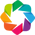

:DynamicMap   []
   :RGB   [lon,lat]   (R,G,B,A)

In [11]:
import datashader
import holoviews as hv
import hvplot.dask
hv.extension('bokeh')

df.hvplot.scatter(
    x="lon", 
    y="lat", 
    aggregator=datashader.by("journey_type"), 
    datashade=True, 
    cnorm="eq_hist",
    frame_width=700, 
    aspect=1.33, 
    color_key={"pickup": "#EF1561", "dropoff": "#1F5AFF"},
)

## Conclusion

Dask DataFrame and Datashader together make it easy to visualize very large scale data. Coiled makes it easy to scale up computing resources in the cloud.

If you have a cloud account it's easy to try this out yourself.  The data is public and this computation costs less than $0.20 in AWS cloud costs.  You can [sign up under the Coiled free tier here](https://coiled.io/start) (setup takes a couple minutes).